# Neural Networks

Manually creating a neural network

In [11]:
class Operation():
    """
    An Operation is a node in a "Graph". 
    TensorFlow will also use this concept of a Graph.
    This Operation class will be inherited by other 
    classes that actually compute the specific 
    operation, such as adding or matrix multiplication.
    """
    def __init__(self, input_nodes = []):
        """
        Intialize an Operation
        """
        self.input_nodes = input_nodes # The list of input nodes
        self.output_nodes = [] # List of nodes consuming this node's output
        for node in input_nodes:
            node.output_nodes.append(self)
        _default_graph.operations.append(self)
    def compute(self):
        """ 
        This is a placeholder function. It will be 
        overwritten by the actual specific operation
        that inherits from this class.
        """
        pass

In [26]:
class add(Operation):
    def __init__(self, x,y):
        super().__init__([x,y])
    def compute(self, x_var, y_var):
        self.inputs = [x_var,y_var]
        return x_var+y_var

In [13]:
class multiply(Operation):
    def __init__(self, a, b):
        super().__init__([a, b])
    def compute(self, a_var, b_var):
        self.inputs = [a_var, b_var]
        return a_var * b_var

In [14]:
class matmul(Operation):
    def __init__(self, a, b):   
        super().__init__([a, b])
    def compute(self, a_mat, b_mat):
        self.inputs = [a_mat, b_mat]
        return a_mat.dot(b_mat)

In [15]:
class Placeholder():
    """
    A placeholder is a node that needs to be provided a 
    value for computing the output in the Graph.
    """
    def __init__(self):
        self.output_nodes = []
        _default_graph.placeholders.append(self)

In [16]:
class Variable():
    def __init__(self, initial_value = None):  
        self.value = initial_value
        self.output_nodes = []
        _default_graph.variables.append(self)

In [22]:
class Graph():
    def __init__(self):
        self.operations = []
        self.placeholders = []
        self.variables = []
    def set_as_default(self):
        """
        Sets this Graph instance as the Global Default Graph
        """
        global _default_graph
        _default_graph = self

In [27]:
# z = Ax + b
g = Graph()
g.set_as_default()
A = Variable(10)
b = Variable(1)
x = Placeholder()
y = multiply(A,x)
z = add(y,b)

Creating the session

In [29]:
def traverse_postorder(operation):
    """ 
    PostOrder Traversal of Nodes. Basically makes sure
    computations are done in the correct order (Ax first, 
    then Ax + b). Feel free to copy and paste this code.
    It is not super important for understanding the 
    basic fundamentals of deep learning.
    """
    nodes_postorder = []
    def recurse(node):
        if isinstance(node, Operation):
            for input_node in node.input_nodes:
                recurse(input_node)
        nodes_postorder.append(node)
    recurse(operation)
    return nodes_postorder

In [43]:
import numpy as np
class Session:
    def run(self, operation, feed_dict = {}):
        """ 
          operation: The operation to compute
          feed_dict: Dictionary mapping placeholders to 
          input values (the data)  
        """
        # Puts nodes in correct order
        nodes_postorder = traverse_postorder(operation)
        for node in nodes_postorder:
            if type(node) == Placeholder:
                node.output = feed_dict[node]
            elif type(node) == Variable:
                node.output = node.value
            else: # Operation
                node.inputs = [input_node.output for input_node in node.input_nodes]
                node.output = node.compute(*node.inputs)
            # Convert lists to numpy arrays
            if type(node.output) == list:
                node.output = np.array(node.output)
        # Return the requested node value
        return operation.output

In [32]:
sess = Session()

In [33]:
result = sess.run(operation=z,feed_dict={x:10})

In [35]:
result #10*10+1=101

101

In [44]:
#Another example
g = Graph()
g.set_as_default()
A = Variable([[10,20],[30,40]])
b = Variable([1,1])
x = Placeholder()
y = matmul(A,x)
z = add(y,b)
sess = Session()
result = sess.run(operation=z,feed_dict={x:10})
result

array([[101, 201],
       [301, 401]])

Activation Function

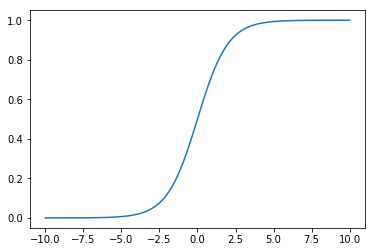

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline
def sigmoid(z):
    return 1/(1+np.exp(-z))
sample_z = np.linspace(-10,10,100)
sample_a = sigmoid(sample_z)
plt.plot(sample_z,sample_a)

In [47]:
class Sigmoid(Operation):
    def __init__(self, z):
        super().__init__([z])
    def compute(self, z_val):
        return 1/(1+np.exp(-z_val))

Classification

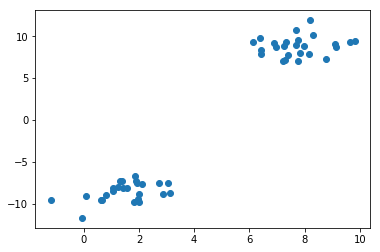

In [48]:
from sklearn.datasets import make_blobs
data = make_blobs(n_samples = 50,n_features=2,centers=2,random_state=75)
features = data[0]
plt.scatter(features[:,0],features[:,1])

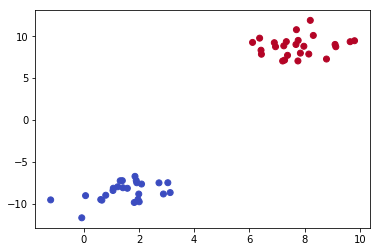

In [49]:
labels = data[1]
plt.scatter(features[:,0],features[:,1],c=labels,cmap='coolwarm')

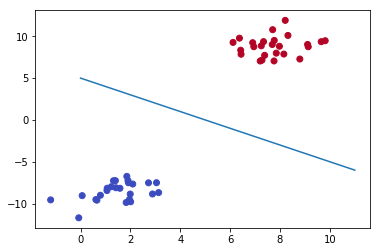

In [50]:
x = np.linspace(0,11,10)
y = -x + 5
plt.scatter(features[:,0],features[:,1],c=labels,cmap='coolwarm')
plt.plot(x,y)

#### Defining the Perceptron

$$ y = mx + b $$

$$ y = -x + 5 $$

$$ f1 = mf2 + b , m=1$$

$$ f1 = -f2 + 5 $$

$$ f1 + f2 - 5 = 0 $$

#### Convert to a Matrix Representation of Features
$$ w^Tx + b = 0 $$

$$   \Big(1, 1\Big)f - 5 = 0 $$

Then if the result is > 0 its label 1, if it is less than 0, it is label=0

#### Example Point

Let's say we have the point f1=2 , f2=2 otherwise stated as (8,10). Then we have:

$$ 
\begin{pmatrix} 
1 , 1
\end{pmatrix} 
\begin{pmatrix} 
8 \\
10
\end{pmatrix} + 5 =  $$

In [53]:
np.array([1, 1]).dot(np.array([[8],[10]])) - 5

array([13])

Using an Example Session Graph

In [55]:
g = Graph()
g.set_as_default()
x = Placeholder()
w = Variable([1,1])
b = Variable(-5)
z = add(matmul(w,x),b)
a = Sigmoid(z)
sess = Session()
sess.run(operation=a,feed_dict={x:[8,10]})

0.99999773967570205

In [56]:
sess.run(operation=a,feed_dict={x:[0,-10]})

3.0590222692562472e-07